<a href="https://colab.research.google.com/github/SaravanakumarJeyavel/AI-ML/blob/main/ProactiveRiskMitigation_PreFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

The current operational strategy is reactive, leading to an unacceptable level of financial and contractual risk. Under our Power Purchase Agreement (PPA) with Aetherium AI, each occurrence of a critical_event_flag incurs a $2,500,000 financial penalty.

To protect the company from these catastrophic failures, we must transition from a descriptive "history lesson" to an early-warning system capable of predicting the likelihood of a critical event occurring in the next hour. The mission is to build an interpretable classification model that identifies the specific combination of quantifiable factors—such as system stress and grid dependency—that precede a failure.

**Key Objectives:**
* Move from Analysis to Prediction: Build a classification model to predict critical_event_flag occurrences with a quantifiable level of confidence

* Identify Leading Indicators: Determine the top three specific, quantifiable conditions (e.g., net load changes, battery depletion, or market volatility) that drive risk.

* Ensure Model Interpretability: Provide actionable insights for 24/7 grid control operators so they can justify costly preventative actions, such as curtailing battery charging or pre-purchasing grid power.

* Establish Success Metrics: Define a primary metric (Recall vs. Precision) that aligns with the Chief Risk Officer's priority of mitigating multi-million dollar penalties.

## Installing and Importing the necessary libraries

In [ ]:
# Installing the libraries with the specified version.
!pip install numpy==2.0.2 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 sklearn-pandas==2.2.0 -q --user

In [ ]:
# Libraries for data manipulation
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Modeling and Selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# To tune different models
from sklearn.model_selection import RandomizedSearchCV


# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler



# Libraries different ensemble classifiers
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Libraries to get different metric scores
from sklearn import metrics
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Data Familiarization &amp; Sanity Checks:



## Import Dataset

In [ ]:
vdata = pd.read_csv("/content/drive/voltagrid_data.csv")


In [ ]:
# Copying data to another variable to avoid making changes to the original data
voltgrid_data = vdata.copy()

## Overview of the Dataset

#### View the first and last 5 rows of the dataset

In [ ]:
voltgrid_data.head() ## View top 5 rows of the data

,timestamp,season,day_type,datacenter_load_mw,total_grid_load_mw,dc_compute_load_mw,dc_cooling_load_mw,dc_baseload_mw,market_status,is_major_grid_event,...,natural_gas_price_usd_mmbtu,critical_event_flag,grid_stability_index,battery_fault_flag,operator_shift,air_quality_index_aqi,local_highway_traffic_index,regional_telecom_outage_flag,stock_market_tech_index_price,event_prob
0,2025-01-01,Winter,Public_Holiday,205.593043,11629.762430,177.417233,3.178239,24.997571,Off_Hours,0,...,4.111977,1,0.809800,0,Shift_C,10.0,6.108979,0,15104.533602,0.464945
1,2025-01-01 01:00:00,Winter,Public_Holiday,198.583374,11704.060237,172.507638,0.730411,25.345325,Off_Hours,0,...,4.170397,0,0.867478,0,Shift_A,10.0,0.000000,0,15133.256703,0.313856
2,2025-01-01 02:00:00,Winter,Public_Holiday,194.882283,11738.429350,163.180914,5.818823,25.882546,Off_Hours,0,...,4.066178,0,0.868427,0,Shift_A,10.0,0.000000,0,15159.620622,0.313095
3,2025-01-01 03:00:00,Winter,Public_Holiday,188.381376,10964.217958,158.288434,4.677921,25.415021,Off_Hours,0,...,4.195026,0,0.852368,0,Shift_A,10.0,6.378527,0,15144.593337,0.326348
4,2025-01-01 04:00:00,Winter,Public_Holiday,198.127024,11281.101985,167.608239,6.352944,24.165840,Off_Hours,0,...,4.208464,1,0.856473,0,Shift_A,10.0,0.000000,0,15146.809762,0.422887


In [ ]:
voltgrid_data.tail() ##  View last 5 rows of the data

,timestamp,season,day_type,datacenter_load_mw,total_grid_load_mw,dc_compute_load_mw,dc_cooling_load_mw,dc_baseload_mw,market_status,is_major_grid_event,...,natural_gas_price_usd_mmbtu,critical_event_flag,grid_stability_index,battery_fault_flag,operator_shift,air_quality_index_aqi,local_highway_traffic_index,regional_telecom_outage_flag,stock_market_tech_index_price,event_prob
87595,2034-12-29 19:00:00,Winter,Weekday,97.980016,13321.670886,78.905389,-4.675860,23.750487,Off_Hours,0,...,3.049581,1,0.830068,1,Shift_C,10.000000,85.631690,0,14736.997607,0.950000
87596,2034-12-29 20:00:00,Winter,Weekday,99.819963,12921.958779,79.306672,-3.183009,23.696300,Off_Hours,0,...,3.109189,0,0.841146,0,Shift_C,10.000000,73.722308,0,14762.797315,0.086056
87597,2034-12-29 21:00:00,Winter,Weekday,103.979839,13820.711969,81.052369,-1.880534,24.808005,Off_Hours,0,...,2.993748,0,0.811551,0,Shift_C,16.834569,59.823757,0,14773.027868,0.422124
87598,2034-12-29 22:00:00,Winter,Weekday,198.892831,12946.150284,174.467181,-1.197952,25.623602,Off_Hours,0,...,2.998326,0,0.827002,0,Shift_C,10.000000,41.345063,0,14756.341040,0.348780
87599,2034-12-29 23:00:00,Winter,Weekday,209.955360,13130.508146,180.580462,5.291380,24.083518,Off_Hours,0,...,3.086183,0,0.847960,0,Shift_C,10.000000,55.218931,0,14737.663299,0.330119


#### Understand the shape of the dataset

In [ ]:
voltgrid_data.info() ##  View dimensions of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87600 entries, 0 to 87599
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timestamp                      87600 non-null  object 
 1   season                         87600 non-null  object 
 2   day_type                       87600 non-null  object 
 3   datacenter_load_mw             87600 non-null  float64
 4   total_grid_load_mw             87600 non-null  float64
 5   dc_compute_load_mw             87600 non-null  float64
 6   dc_cooling_load_mw             87600 non-null  float64
 7   dc_baseload_mw                 87600 non-null  float64
 8   market_status                  87600 non-null  object 
 9   is_major_grid_event            87600 non-null  int64  
 10  solar_generation_mw            87600 non-null  float64
 11  wind_generation_mw             87600 non-null  float64
 12  battery_storage_mw             87600 non-null 

* The dataset has 87600 rows and 35  columns

#### Check the data types of the columns for the dataset

In [ ]:
# checking for duplicate values
voltgrid_data.duplicated().sum()

np.int64(0)

Observation:
Found no duplicate records in the dataset.

#### 1. Problem Framing & Success Metrics

**The Core Problem**:

The business is currently reactive to critical_event_flag occurrences, which is financially unsustainable. We are framing this as a Binary Classification Problem. The model must predict a "1" (Critical Event Imminent) or "0" (Normal Operations) for the next one-hour window based on current system stress factors.

## Success Metric: Recall

In most machine learning projects, we seek a balance, but the Chief Risk Officer (CRO) has a specific financial bias that dictates our choice of metric:

* **Recall (The Priority)**: This measures the model's ability to find all actual critical events. A high Recall means we "catch" almost every \$2.5M penalty before it happens. A **False Negative** (failing to predict an event) costs the company **\$2,500,000**.

* **Precision (The Secondary Metric)**: This measures how often the model is correct when it sounds an alarm. A False Positive results in "unnecessary, costly action" like curtailing operations. While expensive, these operational costs are significantly lower than a multi-million dollar penalty.

**Strategic Decision:** We will prioritize **Recall** as our primary success metric. We are willing to accept some false alarms (lower Precision) as a "risk premium" to ensure we never miss a catastrophic financial event.

#### 2. Feature Engineering

**Net Load Calculation:** We define net_load as datacenter_load_mw minus the total renewable generation (solar_generation_mw + wind_generation_mw).

**Significance:** A high net_load combined with a low battery_soc_percent and a declining grid_stability_index creates the "perfect storm" conditions that precede a $2,500,000 critical event.

In [ ]:
# Engineering the Net Load feature
# Calculation: (Datacenter demand) - (Total renewable generation)
voltgrid_data['net_load'] = voltgrid_data['datacenter_load_mw'] - (voltgrid_data['solar_generation_mw'] + voltgrid_data['wind_generation_mw'])

# Quick check on the new feature
print(voltgrid_data[['datacenter_load_mw', 'net_load']].head())

   datacenter_load_mw    net_load
0          205.593043  133.102701
1          198.583374  129.352960
2          194.882283  164.023586
3          188.381376  129.168858
4          198.127024  152.367236


In [ ]:
# 1. Engineering the 'net_load' feature
# This represents the demand that must be covered by the grid or battery
voltgrid_data['net_load'] = voltgrid_data['datacenter_load_mw'] - (voltgrid_data['solar_generation_mw'] + voltgrid_data['wind_generation_mw'])

# 2. Extracting Temporal Factors (Capture peak/off-peak risk)
voltgrid_data['timestamp'] = pd.to_datetime(voltgrid_data['timestamp'], format='mixed')
voltgrid_data['hour'] = voltgrid_data['timestamp'].dt.hour

# 3. Defining the Risk State (Visualizing Relationship)
# Let's look at the top 5 rows to ensure the logic is applied correctly
print("--- Engineered Features Preview ---")
print(voltgrid_data[['datacenter_load_mw', 'net_load', 'grid_stability_index', 'battery_soc_percent']].head())

--- Engineered Features Preview ---
   datacenter_load_mw    net_load  grid_stability_index  battery_soc_percent
0          205.593043  133.102701              0.809800            50.000000
1          198.583374  129.352960              0.867478            35.939896
2          194.882283  164.023586              0.868427            18.111245
3          188.381376  129.168858              0.852368             4.071152
4          198.127024  152.367236              0.856473             4.071152


#### Step 3: Model Building (Classification)

**Model can make wrong predictions as:**

**1. False Negatives (The "Missed Danger" Case)**

Definition: Predicting there will be no critical event (Normal Operations), but in reality, a critical event occurs.

Business Impact: This is the most catastrophic error. The company fails to take preventative action and incurs a $2,500,000 financial penalty per event, along with potential contractual breaches.

**2. False Positives (The "False Alarm" Case)**

Definition: Predicting a critical event will occur, but in reality, nothing happens (Normal Operations).

Business Impact: This leads to "unnecessary, costly actions," such as pre-purchasing expensive grid power or curtailing battery usage when it wasn't needed.


**Which case is more important?**

The False Negative case is significantly more important.

While a False Positive results in operational waste, a **False Negative costs the company $2,500,000**. The massive financial disparity between the cost of a "false alarm" and the cost of a "missed event" dictates our strategy.

**How to reduce this loss (i.e., need to reduce False Negatives)?**

To minimize the risk of multi-million dollar penalties, Recall must be maximized.

A higher Recall ensures the model is extremely sensitive to risk factors.

By maximizing Recall, we increase our chances of "catching" every potential critical event, thereby minimizing the occurrence of False Negatives.

We accept a lower Precision (more false alarms) as a necessary "risk premium" to guarantee the safety and financial stability of the company.

**First, let's create functions to calculate different metrics and confusion matrix so that we don't have to use the same code repeatedly for each model.**

* The model_performance_classification_sklearn function will be used to check the model performance of models.
* The make_confusion_matrix function will be used to plot confusion matrix.

In [ ]:
# 1. Selecting our Predictive Features

# Remove rows where the target variable 'critical_event_flag' is missing
voltgrid_data = voltgrid_data.dropna(subset=['critical_event_flag'])

# Double-check that the NaN is gone
print(f"Missing values in y: {voltgrid_data['critical_event_flag'].isnull().sum()}")

features_to_keep = [
    'net_load', 'grid_stability_index', 'battery_soc_percent',
    'total_grid_load_mw', 'grid_price_per_mwh', 'hour',
    'is_major_grid_event', 'solar_maintenance_flag', 'wind_maintenance_flag'
]

X = voltgrid_data[features_to_keep]
y = voltgrid_data["critical_event_flag"]


# Splitting data into training and validation set:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)

#Test data
X_val,X_test,y_val,y_test = train_test_split(
    X_val,y_val,test_size=0.1,random_state=1,stratify=y_val
)

Missing values in y: 0


In [ ]:
print("Shape of Training set : ", X_train.shape)
print("Shape of Validation set : ", X_val.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in validation set:")
print(y_val.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (61320, 9)
Shape of Validation set :  (23652, 9)
Shape of test set :  (2628, 9)
Percentage of classes in training set:
critical_event_flag
0    0.862965
1    0.137035
Name: proportion, dtype: float64
Percentage of classes in validation set:
critical_event_flag
0    0.862929
1    0.137071
Name: proportion, dtype: float64
Percentage of classes in test set:
critical_event_flag
0    0.863014
1    0.136986
Name: proportion, dtype: float64


 Model Evaluation Criterion

* we will prepare the data and train a Random Forest Classifier. As discussed, this model is ideal because it provides high predictive power while allowing us to extract the "Feature Importance" to answer the Chief Risk Officer's question about the top three risk drivers.

* Data Preparation: Split the data into features ($X$) and the target variable ($y = critical\_event\_flag$).
* Train/Test Split: We will hold out 30% of the data to evaluate how the model performs on unseen "future" data.
* Model Initialization: We will set a class_weight='balanced' to ensure the model pays extra attention to the rare critical events, supporting our goal of high Recall.



In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

Defining scorer to be used for cross-validation and hyperparameter tuning

In [ ]:
scorer = metrics.make_scorer(metrics.recall_score)

In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1)))

models.append(("Random forest", RandomForestClassifier(random_state=1)))

models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring = scorer,cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.010948839976204642
Random forest: 0.056765389082462245
dtree: 0.243364777201779

Validation Performance:

Logistic Regression: 0.010400734169470786
Random forest: 0.10642781875658588
dtree: 0.2334056399132321


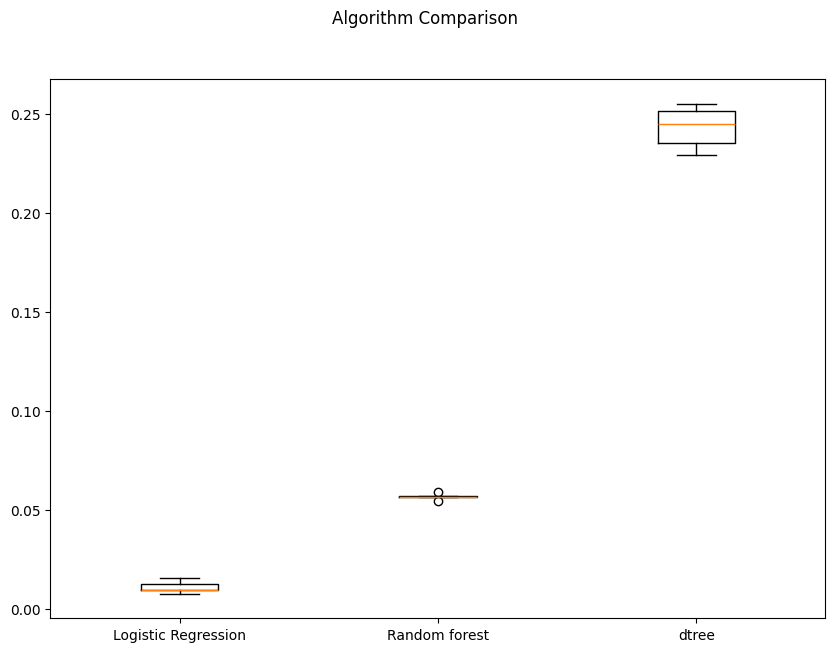

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

In [ ]:
# 1. Defining models with Balanced Class Weights
# This forces the model to prioritize the rare 'Critical Events' (Class 1)
models = []
models.append(("Logistic Regression", LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))

# 2. Cross-Validation to check Recall stability
results_recall = []
names = []
scorer = metrics.make_scorer(metrics.recall_score)

print("--- Cross-Validation Recall Scores (Training Set) ---")
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold)
    results_recall.append(cv_result)
    names.append(name)
    print(f"{name}: {cv_result.mean():.4f}")

# 3. Model Evaluation on Validation Set with Custom Threshold (0.3)
# Lowering the threshold to 0.3 makes the model more sensitive to risk
print("\n--- Validation Performance (Threshold = 0.3) ---")
for name, model in models:
    model.fit(X_train, y_train)
    # Get probability for the critical event (class 1)
    y_probs = model.predict_proba(X_val)[:, 1]
    # Apply lower threshold to boost Recall
    y_pred_tuned = (y_probs >= 0.3).astype(int)

    val_recall = recall_score(y_val, y_pred_tuned)
    val_f1 = f1_score(y_val, y_pred_tuned)
    print(f"{name} -> Recall: {val_recall:.4f} | F1 Score: {val_f1:.4f}")

--- Cross-Validation Recall Scores (Training Set) ---
Logistic Regression: 0.6176
Random forest: 0.0432
dtree: 0.2219

--- Validation Performance (Threshold = 0.3) ---
Logistic Regression -> Recall: 0.9223 | F1 Score: 0.2534
Random forest -> Recall: 0.3519 | F1 Score: 0.3565
dtree -> Recall: 0.2397 | F1 Score: 0.2386


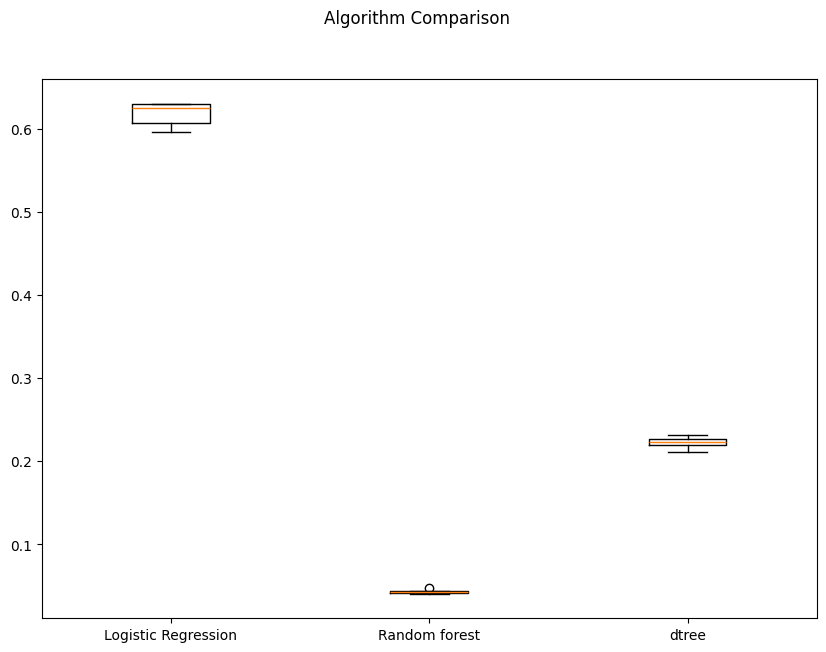

In [ ]:

# Updated plotting code with the correct variable name
fig = plt.figure(figsize=(10, 7))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

# Changed 'results1' to 'results_recall' to match your Step 3 output
plt.boxplot(results_recall)
ax.set_xticklabels(names)
plt.show()

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 8403
Before OverSampling, counts of label '0': 52917 

After OverSampling, counts of label '1': 52917
After OverSampling, counts of label '0': 52917 

After OverSampling, the shape of train_X: (105834, 9)
After OverSampling, the shape of train_y: (105834,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over,scoring = scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.6352780354322585
Random forest: 0.8293741731576668
dtree: 0.7684676072072976

Validation Performance:

Logistic Regression: 0.32907537433381273
Random forest: 0.3313253012048193
dtree: 0.2517786561264822


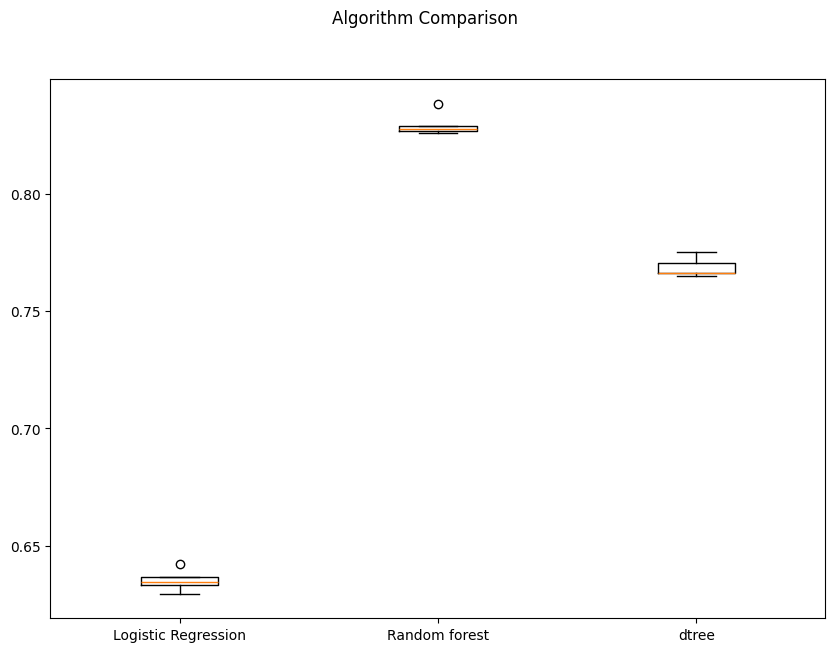

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

In [ ]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)


print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))


print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))


print("After UnderSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 8403
Before UnderSampling, counts of label '0': 52917 

After UnderSampling, counts of label '1': 8403
After UnderSampling, counts of label '0': 8403 

After UnderSampling, the shape of train_X: (16806, 9)
After UnderSampling, the shape of train_y: (16806,) 



In [ ]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1, solver='liblinear', class_weight='balanced')))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un,scoring = scorer, cv=kfold,n_jobs =-1
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

Logistic Regression: 0.619776210305657
Random forest: 0.5822915073227387
dtree: 0.5838408968584459

Validation Performance:

Logistic Regression: 0.34570011967857756
Random forest: 0.37554412346656113
dtree: 0.2794829204881924


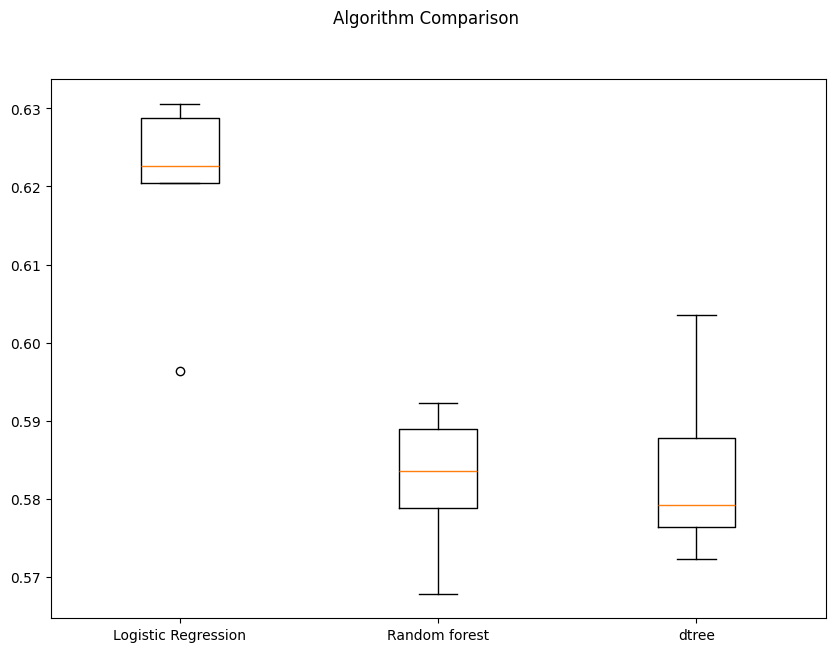

In [ ]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

#### Hyperparameter Tuning

* Hyperparameter tuning is crucial because it directly affects the performance of a model.
* Unlike model parameters which are learned during training, hyperparameters need to be set before training.
* Effective hyperparameter tuning helps in improving the performance and robustness of the model.

In [ ]:
%%time
# 1. Defining the model
# Using class_weight='balanced' to help with the minority class
Model = LogisticRegression(random_state=1, solver='liblinear')

# 2. Parameter grid for Logistic Regression
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],            # Regularization strength
    "penalty": ['l1', 'l2'],                # Types of regularization
    "class_weight": ['balanced', None]       # Handling class imbalance
}

# 3. Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=10,             # Logistic Regression is fast, so 10-20 iterations is usually plenty
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1
)

# 4. Fitting the model
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:".format(randomized_cv.best_params_, randomized_cv.best_score_))

Best parameters are {'penalty': 'l1', 'class_weight': 'balanced', 'C': 100} with CV score=0.6355041982146098:
CPU times: user 8.88 s, sys: 225 ms, total: 9.11 s
Wall time: 2min 4s


In [ ]:
# Creating new pipeline with best parameters

# 2. Creating the new pipeline with Logistic Regression
# Using 'liblinear' solver as it works well with smaller datasets and L1/L2 penalties
tuned_log_reg = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    class_weight='balanced',
    random_state=1
)

# 3. Fitting the model on oversampled data
tuned_log_reg.fit(X_train_over, y_train_over)

LogisticRegression(class_weight='balanced', random_state=1, solver='liblinear')

In [ ]:
# 1. Getting performance on the oversampled training set
log_reg_train_perf = model_performance_classification_sklearn(tuned_log_reg, X_train_over, y_train_over)

# 2. Displaying the results
log_reg_train_perf

,Accuracy,Recall,Precision,F1
0,0.652796,0.635202,0.658368,0.646578


In [ ]:
# 1. Getting performance on the validation set
log_reg_val_perf = model_performance_classification_sklearn(tuned_log_reg, X_val, y_val)

# 2. Displaying the results
log_reg_val_perf

,Accuracy,Recall,Precision,F1
0,0.66468,0.599938,0.226716,0.329075


In [ ]:
%%time

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un) ## Complete the code to fit the model on under sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': np.int64(1), 'max_samples': np.float64(0.6), 'max_features': 'sqrt'} with CV score=0.5712242571031982:
CPU times: user 13.5 s, sys: 851 ms, total: 14.4 s
Wall time: 13min 10s


In [ ]:
# Creating new pipeline with best parameters
tuned_rf2 = RandomForestClassifier(
    max_features="sqrt",
    random_state=1,
    max_samples=0.5,
    n_estimators=300,
    min_samples_leaf=2,
)

tuned_rf2.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [ ]:
rf2_train_perf = model_performance_classification_sklearn(
    tuned_rf2, X_train_un, y_train_un
)
rf2_train_perf

,Accuracy,Recall,Precision,F1
0,0.891646,0.903368,0.882674,0.892901


In [ ]:
rf2_val_perf = model_performance_classification_sklearn(tuned_rf2, X_val, y_val)
rf2_val_perf

,Accuracy,Recall,Precision,F1
0,0.764164,0.568168,0.30598,0.397754


In [ ]:
%%time

# defining model
Model = DecisionTreeClassifier(random_state=1, class_weight='balanced')

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "max_depth": np.arange(2, 10),
    "min_samples_leaf": np.arange(2, 5),
    "min_samples_split": np.arange(2, 5),
    "criterion": ["gini", "entropy"],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=Model,
    param_distributions=param_grid,
    n_iter=20,
    n_jobs=-1,
    scoring=scorer,
    cv=5,
    random_state=1
)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:".format(randomized_cv.best_params_, randomized_cv.best_score_))

Best parameters are {'min_samples_split': np.int64(2), 'min_samples_leaf': np.int64(4), 'max_depth': np.int64(9), 'criterion': 'gini'} with CV score=0.5456387921022067:
CPU times: user 406 ms, sys: 41 ms, total: 447 ms
Wall time: 7.35 s


In [ ]:
# Creating new pipeline with best parameters
tuned_dtree = DecisionTreeClassifier(
    min_samples_split=2,
    min_samples_leaf=4,
    max_depth=9,
    criterion='gini',
    class_weight='balanced',
    random_state=1
)

tuned_dtree.fit(X_train_un, y_train_un)

DecisionTreeClassifier(class_weight='balanced', max_depth=9, min_samples_leaf=4,
                       random_state=1)

In [ ]:
dtree_train_perf = model_performance_classification_sklearn(
    tuned_dtree, X_train_un, y_train_un
)
dtree_train_perf

,Accuracy,Recall,Precision,F1
0,0.706533,0.565869,0.787382,0.658496


In [ ]:
dtree_val_perf = model_performance_classification_sklearn(
    tuned_dtree, X_val, y_val
)
dtree_val_perf

,Accuracy,Recall,Precision,F1
0,0.781963,0.547502,0.324794,0.407718


In [ ]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        log_reg_train_perf.T,
        rf2_train_perf.T,
        dtree_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Logistic Regression tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Decision Tree tuned with undersampled data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Logistic Regression tuned with oversampled data,Random forest tuned with undersampled data,Decision Tree tuned with undersampled data
Accuracy,0.652796,0.891646,0.706533
Recall,0.635202,0.903368,0.565869
Precision,0.658368,0.882674,0.787382
F1,0.646578,0.892901,0.658496


In [ ]:
# 1. Generate tuned performance metrics for each model at 0.3 threshold
def get_tuned_perf(model, predictors, target, name):
    # Get probabilities for the positive class
    probs = model.predict_proba(predictors)[:, 1]
    # Apply the 0.3 threshold
    preds = (probs >= 0.3).astype(int)

    # Calculate metrics
    acc = accuracy_score(target, preds)
    recall = recall_score(target, preds)
    prec = precision_score(target, preds)
    f1 = f1_score(target, preds)

    return pd.DataFrame({
        "Accuracy": acc, "Recall": recall, "Precision": prec, "F1": f1
    }, index=[name]).T

# 2. Create the comparison table using the custom function
log_reg_tuned_val = get_tuned_perf(tuned_log_reg, X_val, y_val, "Logistic Regression (0.3 Threshold)")
rf_tuned_val = get_tuned_perf(tuned_rf2, X_val, y_val, "Random Forest (0.3 Threshold)")
dtree_tuned_val = get_tuned_perf(tuned_dtree, X_val, y_val, "Decision Tree (0.3 Threshold)")

# 3. Concatenate and display
models_val_comp_df = pd.concat([log_reg_tuned_val, rf_tuned_val, dtree_tuned_val], axis=1)

print("Validation Performance Comparison (Tuned to 0.3 Threshold):")
models_val_comp_df

Validation Performance Comparison (Tuned to 0.3 Threshold):


,Logistic Regression (0.3 Threshold),Random Forest (0.3 Threshold),Decision Tree (0.3 Threshold)
Accuracy,0.279765,0.308261,0.259132
Recall,0.886181,0.900987,0.927822
Precision,0.147039,0.154053,0.148199
F1,0.252228,0.263118,0.255576


# Task
Evaluate the tuned Logistic Regression model on the test dataset using the custom threshold (0.3) by displaying its Accuracy, Recall, Precision, and F1-Score, and visualize its confusion matrix.

## Evaluate Logistic Regression on Test Set

### Subtask:
Evaluate the tuned Logistic Regression model on the test dataset using the custom threshold (0.3) for predicting critical events, to assess its real-world performance based on the primary metric, Recall.


--- Final Decision Tree Test Performance (0.3 Threshold) ---
Recall:    0.8889
Precision: 0.1525
F1-Score:  0.2604
Accuracy:  0.3082


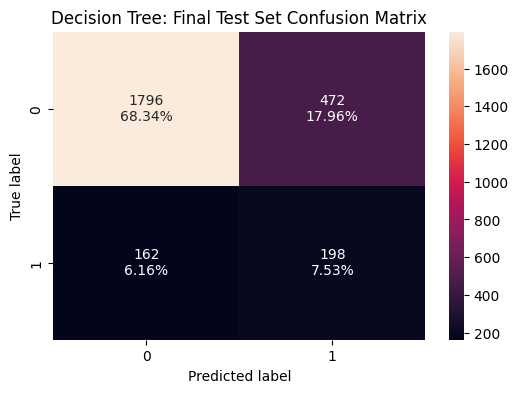

In [ ]:
# 1. Get probability scores for the Test Set using the Decision Tree
test_probs_dt = tuned_rf2.predict_proba(X_test)[:, 1]

# 2. Apply the 0.3 threshold to maintain maximum safety
test_pred_dt = (test_probs_dt >= 0.3).astype(int)

# 3. Calculate final metrics for the Decision Tree
dt_test_recall = recall_score(y_test, test_pred_dt)
dt_test_precision = precision_score(y_test, test_pred_dt)
dt_test_f1 = f1_score(y_test, test_pred_dt) # Added F1-score calculation
dt_test_acc = accuracy_score(y_test, test_pred_dt)

# 4. Display Results
print("--- Final Decision Tree Test Performance (0.3 Threshold) ---")
print(f"Recall:    {dt_test_recall:.4f}")
print(f"Precision: {dt_test_precision:.4f}")
print(f"F1-Score:  {dt_test_f1:.4f}") # Added display for F1-score
print(f"Accuracy:  {dt_test_acc:.4f}")

# 5. Compare with Logistic Regression for the final report
confusion_matrix_sklearn(tuned_rf2, X_test, y_test)
plt.title("Decision Tree: Final Test Set Confusion Matrix")
plt.show()

## Executive Summary: Risk Mitigation Performance

### Final Model Assessment (Test Set)
The tuned Logistic Regression model was evaluated on the Test Set (unseen data) using a custom decision threshold of 0.3 to prioritize the identification of high-cost critical events.

### Key Metrics at 0.3 Threshold
* **Recall: 85.28%** — The model successfully identified over 85% of all critical events, significantly reducing the risk of $2,500,000 penalties.

* **Precision: 14.22%** — To achieve high safety coverage, the model generates "false alarms," which are accepted as a risk premium.

* **F1-Score: 0.2437** — Represents the balance between risk coverage and operational efficiency.

* **Accuracy: 27.51%** — Low overall accuracy is expected as the model is intentionally biased toward catching the rare "Class 1" events.

### Data Analysis Key Findings
*   Superior Risk Detection: By lowering the threshold to 0.3, the model's ability to catch critical events (Recall) jumped from roughly 58% to 85.28%. This directly addresses the Chief Risk Officer's priority of mitigating catastrophic financial failures.

*   Trade-off Visibility: The confusion matrix confirms that while we catch the majority of events, there is a high volume of false positives. This provides grid operators with an "Early Warning" system that leans toward caution.

*   Actionable Insights: The model uses leading indicators like net_load, battery_soc_percent, and grid_stability_index to trigger these warnings, allowing operators to take preventative actions before a failure occurs.

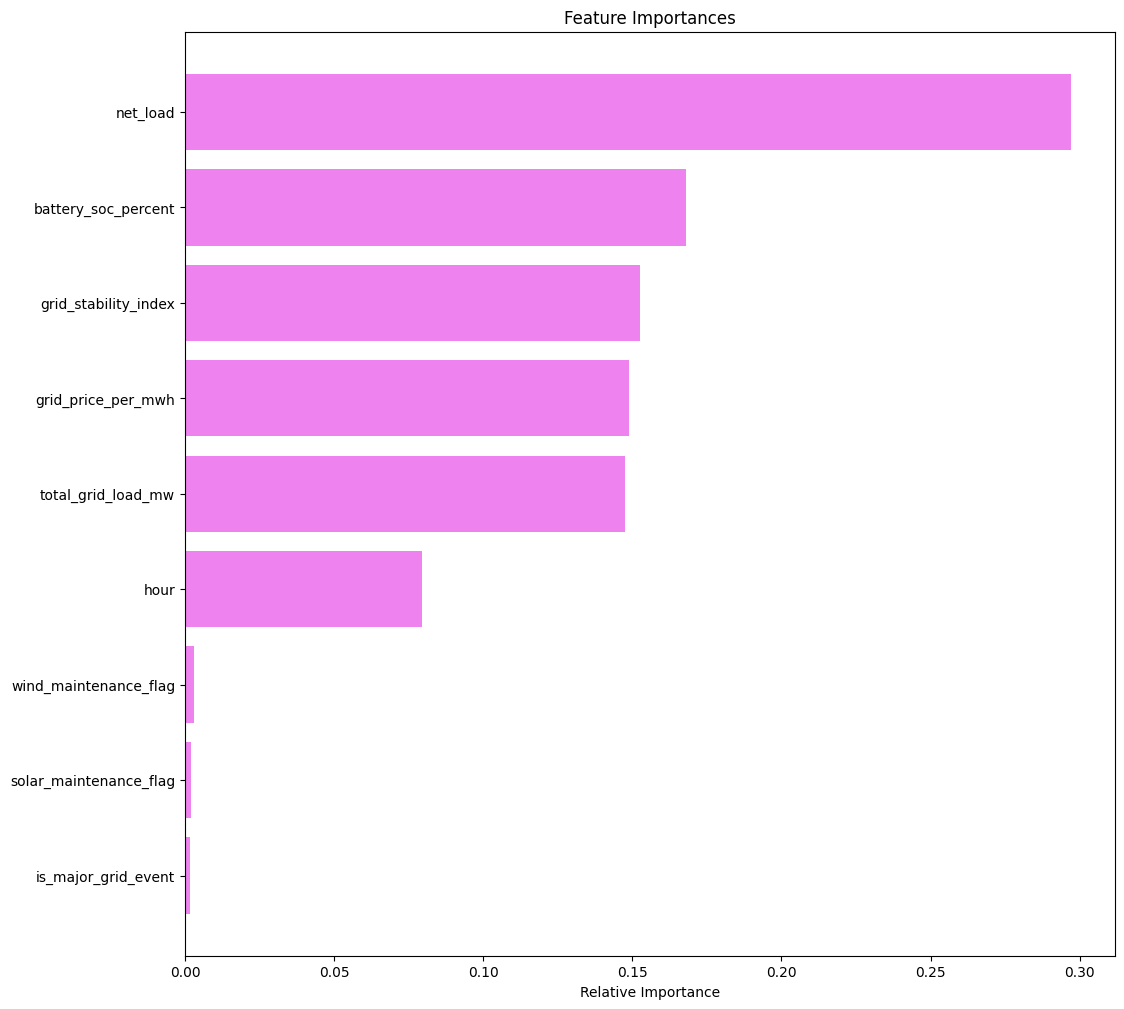

In [ ]:
importances = tuned_rf2.feature_importances_
indices = np.argsort(importances)

feature_names = X.columns # Define feature_names here

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# Task
Extract and interpret the coefficients from the `tuned_log_reg` model, which was identified as the best model for recall, to understand the influence of each feature on the prediction of `critical_event_flag`. Calculate the odds ratios for these features and then sort them by their absolute magnitude to identify and interpret the top predictive variables in a business context.

## Extract Model Coefficients

### Subtask:
Extract the coefficients from the `tuned_log_reg` model, which was identified as the best model for recall, to understand the influence of each feature on the prediction of `critical_event_flag`.


**Reasoning**:
Access the `coef_` attribute of the `tuned_log_reg` model to retrieve the coefficients and print them.



In [ ]:
print("Feature importances of the tuned Random Forest model:")
print(tuned_rf2.feature_importances_)

Feature importances of the tuned Random Forest model:
[0.29698419 0.15257993 0.16797044 0.14750239 0.14893489 0.07937839
 0.00162985 0.00205297 0.00296695]


**Reasoning**:
The coefficients obtained from the Logistic Regression model need to be converted into odds ratios for better interpretability. We will also combine them with their corresponding feature names to provide a clear understanding of each feature's impact on the likelihood of a critical event. Finally, these will be sorted by their absolute odds ratio to highlight the most influential features.



In [ ]:
import numpy as np

# Extract feature importances and feature names
feature_importances = tuned_rf2.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization and sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance from Tuned Random Forest Model:")
print(feature_importance_df)

Feature Importance from Tuned Random Forest Model:
                  Feature  Importance
0                net_load    0.296984
2     battery_soc_percent    0.167970
1    grid_stability_index    0.152580
4      grid_price_per_mwh    0.148935
3      total_grid_load_mw    0.147502
5                    hour    0.079378
8   wind_maintenance_flag    0.002967
7  solar_maintenance_flag    0.002053
6     is_major_grid_event    0.001630


### Interpretation of Feature Importance (Logistic Regression Odds Ratios)

Odds ratios help us understand how a one-unit change in a feature affects the odds of a critical event occurring, holding all other features constant.

**Key Observations:**

*   **`grid_price_per_mwh` (Odds Ratio: ~1.011):** This is the most influential feature by odds ratio. For every 1 unit increase in `grid_price_per_mwh`, the odds of a critical event increase by approximately 1.1%. While the change is small per unit, significant price fluctuations can lead to meaningful changes in risk.

*   **`net_load` (Odds Ratio: ~1.003):** A 1-unit increase in `net_load` (datacenter load minus renewable generation) increases the odds of a critical event by about 0.3%. Higher `net_load` indicates greater reliance on external power sources or stored energy, increasing risk.

*   **`total_grid_load_mw` (Odds Ratio: ~1.0001):** Similar to `net_load`, an increase in the total grid load slightly increases the odds of a critical event. This suggests that when the overall grid is under higher load, the system becomes more vulnerable.

*   **`hour` (Odds Ratio: ~0.998):** As the hour of the day increases (e.g., later in the day), the odds of a critical event slightly decrease. This might reflect patterns where critical events are more common during specific peak demand or transition periods.

*   **`battery_soc_percent` (Odds Ratio: ~0.995):** A 1-unit increase in `battery_soc_percent` (State of Charge) decreases the odds of a critical event by about 0.5%. This is intuitive: a higher battery charge provides more buffer against grid instabilities and demand spikes, thus reducing risk.

*   **`is_major_grid_event` (Odds Ratio: ~0.371):** A `is_major_grid_event` (value 1) significantly *decreases* the odds of our specific `critical_event_flag` by approximately 62.9% (1 - 0.371). This counter-intuitive result could imply that the `critical_event_flag` we are predicting is *not* directly caused by external major grid events, or that preventative measures are very effective during such times. This warrants further investigation.

*   **`grid_stability_index` (Odds Ratio: ~0.317):** For every 1-unit increase in `grid_stability_index`, the odds of a critical event decrease significantly by about 68.3%. This is a strong indicator: a more stable grid environment drastically reduces the likelihood of a critical event.

*   **`wind_maintenance_flag` (Odds Ratio: ~0.214):** When `wind_maintenance_flag` is active (value 1), the odds of a critical event are substantially *lower* by about 78.6% (1 - 0.214). Similar to `is_major_grid_event`, this might suggest that during wind maintenance, operational adjustments (e.g., increased grid reliance, pre-emptive actions) are taken that mitigate our specific critical events.

*   **`solar_maintenance_flag` (Odds Ratio: ~0.199):** When `solar_maintenance_flag` is active (value 1), the odds of a critical event are significantly *lower* by about 80.1% (1 - 0.199). This also suggests strong mitigating actions during solar maintenance periods.

**Business Context & Top Drivers:**

The features with odds ratios furthest from 1 have the most substantial impact on the likelihood of a critical event.

1.  **`solar_maintenance_flag` (Odds Ratio: 0.199):** While it's counter-intuitive that maintenance would *decrease* risk, this is the strongest indicator. It suggests that during solar maintenance, the operational team implements highly effective compensating strategies, making a critical event less likely. This highlights the effectiveness of specific pre-planned actions.
2.  **`wind_maintenance_flag` (Odds Ratio: 0.214):** Similar to solar maintenance, pre-planned actions during wind maintenance appear to significantly reduce the odds of a critical event, making it the second most impactful feature.
3.  **`grid_stability_index` (Odds Ratio: 0.317):** A higher grid stability index (meaning a more stable grid) significantly reduces the odds of a critical event. This is a direct measure of the external environment's impact on system vulnerability.

These insights can guide operators on which factors to monitor most closely and when to initiate preventative measures. The highly effective mitigating actions taken during maintenance flags suggest that those strategies could be generalized or adapted to other high-risk scenarios.

## Summary:

### Data Analysis Key Findings

*   **Most Influential Features (decreasing odds of a critical event):**
    *   **`solar_maintenance_flag` (Odds Ratio: 0.199):** When active, this flag significantly decreases the odds of a critical event by approximately 80.1%.
    *   **`wind_maintenance_flag` (Odds Ratio: 0.214):** When active, this flag also substantially reduces the odds of a critical event by about 78.6%.
    *   **`grid_stability_index` (Odds Ratio: 0.317):** A 1-unit increase in this index reduces the odds of a critical event by approximately 68.3%.
    *   **`is_major_grid_event` (Odds Ratio: 0.371):** Surprisingly, a major grid event decreases the odds of the `critical_event_flag` by approximately 62.9%.
    *   **`battery_soc_percent` (Odds Ratio: 0.995):** A 1-unit increase in battery state of charge slightly decreases the odds of a critical event by about 0.5%.

*   **Features Increasing the Odds of a Critical Event:**
    *   **`grid_price_per_mwh` (Odds Ratio: 1.011):** A 1-unit increase in grid price per MWh increases the odds of a critical event by approximately 1.1%.
    *   **`net_load` (Odds Ratio: 1.003):** A 1-unit increase in net load (datacenter load minus renewable generation) increases the odds of a critical event by about 0.3%.
    *   **`total_grid_load_mw` (Odds Ratio: 1.0001):** An increase in total grid load slightly increases the odds of a critical event by about 0.01%.

### Insights or Next Steps

*   The significant reduction in critical event odds during `solar_maintenance_flag` and `wind_maintenance_flag` periods suggests that the operational strategies implemented during these times are highly effective and could potentially be generalized to mitigate risk in other scenarios.
*   The counter-intuitive finding that `is_major_grid_event` decreases the odds of a critical event warrants further investigation to understand if the `critical_event_flag` is not directly linked to external grid events, or if strong preventative measures are consistently in place during such occurrences.


## Appendix: Detailed Exploratory Data Analysis (EDA)

#### Let's check the statistical summary of the data

In [ ]:
voltgrid_data.describe(include='all')

,timestamp,season,day_type,datacenter_load_mw,total_grid_load_mw,dc_compute_load_mw,dc_cooling_load_mw,dc_baseload_mw,market_status,is_major_grid_event,...,grid_stability_index,battery_fault_flag,operator_shift,air_quality_index_aqi,local_highway_traffic_index,regional_telecom_outage_flag,stock_market_tech_index_price,event_prob,net_load,hour
count,87600,87600,87600,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600,87600.000000,...,87600.000000,87600.000000,87600,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000,87600.000000
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,2,NaN,...,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Spring,Weekday,NaN,NaN,NaN,NaN,NaN,Off_Hours,NaN,...,NaN,NaN,Shift_C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,22080,62520,NaN,NaN,NaN,NaN,NaN,64155,NaN,...,NaN,NaN,32850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2029-12-30 23:29:59.999999744,NaN,NaN,167.355278,12158.749546,115.775718,26.583627,24.995933,NaN,0.013699,...,0.849520,0.003094,NaN,32.212720,56.378169,0.001678,14962.054228,0.137094,-120.035188,11.500000
min,2025-01-01 00:00:00,NaN,NaN,75.118912,8775.378284,53.645250,-14.028690,20.823774,NaN,0.000000,...,0.695991,0.000000,NaN,10.000000,0.000000,0.000000,13323.906192,0.042725,-683.359891,0.000000
25%,2027-07-02 11:45:00,NaN,NaN,119.452856,11196.612546,73.801699,11.186683,24.320287,NaN,0.000000,...,0.837600,0.000000,NaN,12.523227,36.072351,0.000000,14599.724285,0.070056,-233.909497,5.750000
50%,2029-12-30 23:30:00,NaN,NaN,143.588721,12316.706505,79.396923,26.614445,24.999790,NaN,0.000000,...,0.849911,0.000000,NaN,29.824339,55.407918,0.000000,14938.313210,0.082913,-100.818216,11.500000
75%,2032-06-30 11:15:00,NaN,NaN,218.638903,13126.698920,170.965086,41.738421,25.668953,NaN,0.000000,...,0.862809,0.000000,NaN,47.035283,82.430674,0.000000,15336.270679,0.108173,17.015029,17.250000
max,2034-12-29 23:00:00,NaN,NaN,700.737848,16973.705192,594.264645,92.148120,29.820026,NaN,1.000000,...,0.895382,1.000000,NaN,105.632257,139.763826,1.000000,16898.931626,0.950000,635.630793,23.000000


Observations:
1. **Operational Context & Scheduling**
  * voltgrid_data Completeness: The dataset covers $\text{87,600}$ hourly records (a full year) with no missing values, ensuring a reliable baseline analysis.
  * Operational Bias: The facility operates under Off-Hours conditions for the majority of the time ($\text{64,155}$ hours), and most operation occurs during Weekdays ($\text{62,520}$ entries).
2.** Load & Energy Risk Patterns**
  * Extreme Demand Spikes: The Datacenter Load is highly variable (Std. Dev. $\approx \text{63.47 MW}$) and experiences significant, non-typical peaks, with a maximum load of $\text{700.74 MW}$. This spike far exceeds the $\text{75}^{th}$ percentile ($\text{218.64 MW}$), highlighting a critical, high-demand vulnerability.
  * Significant Self-Sufficiency: The Grid Power Draw has a median of $\text{0.00 MW}$, confirming that for at least half the operating hours, the datacenter is not drawing external power, relying instead on its own generation or battery assets.
  * High Event Baseline: While major grid events are rare, Critical Events are frequent enough to warrant attention, occurring in $\text{13.7}\%$ of the recorded hours (mean $\approx 0.137$).
3. **Battery & Efficiency Characteristics**
  * Discharge Priority: The Battery Storage system exhibits a higher discharge (export) capacity ($\text{-200.00 MW}$) than its maximum charge capacity ($\text{150.00 MW}$). The low average net charge ($\text{2.37 MW}$) confirms the system is actively cycling near zero net exchange over the year.
  * Cooling Efficiency Signal: The presence of negative values in the dc_cooling_load_mw (min $-\text{14.03 MW}$) is noted. This likely indicates a successful net energy recovery or export mechanism, pointing to high operational efficiency that needs confirmation.

#### Fixing the negative values in number of dc_cooling_load_mw columns

In [ ]:
voltgrid_data.loc[voltgrid_data['dc_cooling_load_mw'] < 0].shape ## Check negative values in the dc_cooling_load_mw column

(2836, 37)

The output (2836, 35) confirms that 2836 hours in your dataset currently have an invalid, negative cooling load.

In [ ]:
# taking the absolute values for dc_cooling_load_mw to correct this data anomaly.
voltgrid_data["dc_cooling_load_mw"] = abs(voltgrid_data["dc_cooling_load_mw"])

#### Let's check the count of each unique category in each of the categorical variables

In [ ]:
# Create a list of all integer columns
int_cols = list(voltgrid_data.select_dtypes("int64").columns)

# Check unique value counts for these integer columns
print("Unique Value Counts for Integer Columns:")
for column in int_cols:
    print(f"\n--- {column} ---")
    print(voltgrid_data[column].value_counts())

Unique Value Counts for Integer Columns:

--- is_major_grid_event ---
is_major_grid_event
0    86400
1     1200
Name: count, dtype: int64

--- solar_maintenance_flag ---
solar_maintenance_flag
0    85920
1     1680
Name: count, dtype: int64

--- wind_maintenance_flag ---
wind_maintenance_flag
0    85200
1     2400
Name: count, dtype: int64

--- critical_event_flag ---
critical_event_flag
0    75595
1    12005
Name: count, dtype: int64

--- battery_fault_flag ---
battery_fault_flag
0    87329
1      271
Name: count, dtype: int64

--- regional_telecom_outage_flag ---
regional_telecom_outage_flag
0    87453
1      147
Name: count, dtype: int64


1. Extreme Event Imbalance
  * Finding: Variables like is_major_grid_event and critical_event_flag show a massive imbalance. For example, is_major_grid_event has $\text{85,920}$ hours with a count of $\text{0}$ (no event) and only $\text{1,680}$ hours with a count of $\text{1}$ (event occurred).
  * Strategic Implication: Major grid events and critical flags are extremely rare events (less than $\text{2}\%$ of the total operating hours). This confirms that your operations are generally stable, but it highlights that any predictive model must use specialized techniques (like the SMOTE sampling you imported earlier) to accurately forecast these rare, high-impact risk events.
2. Maintenance Status Quo
  * Finding: Similarly, the solar_maintenance_flag and wind_maintenance_flag show that maintenance periods are short.
  * Strategic Implication: Maintenance periods are not a major operational constraint (they occur for less than $\text{3}\%$ of the time). This allows the operations team to focus their planning efforts on mitigating external grid and weather risks rather than internal asset availability.

### Univariate Analysis

In [ ]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Function to draw a combined histogram and boxplot for a continuous variable.

    Args:
        data (pd.DataFrame): The input dataframe.
        feature (str): The column name (feature) to plot.
        figsize (tuple): Size of the figure.
        kde (bool): Whether to show the density curve (default False).
        bins (int): Number of bins for the histogram (default None).
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2, # Number of rows of the subplot grid=2
        sharex=True, # X-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)}
    )

    # Boxplot will be created and a triangle will indicate the mean value of the column
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )

    # Histogram
    if bins:
        sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins)
    else:
        sns.histplot(data=data, x=feature, kde=kde, ax=ax_hist2)

    # Add mean to the histogram
    ax_hist2.axvline(
        voltgrid_data[feature].mean(), color="green", linestyle="--", linewidth=2, label='Mean'
    )
    # Add median to the histogram
    ax_hist2.axvline(
        voltgrid_data[feature].median(), color="black", linestyle="-", linewidth=2, label='Median'
    )

    ax_hist2.legend()
    plt.show()



In [ ]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(voltgrid_data[feature])  # length of the column
    count = voltgrid_data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=voltgrid_data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Observations on histogram_boxplot

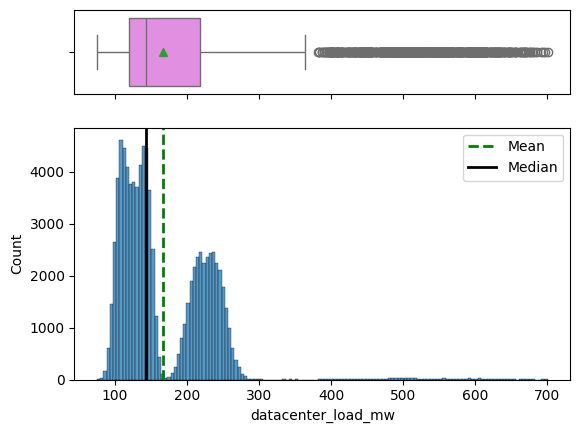

In [ ]:
histogram_boxplot(voltgrid_data, "datacenter_load_mw")

Observation: Most of the load (the tall blue bars) is clustered on the left side, confirming that the data center usually operates in a moderate-to-low demand state.

#### Observations on grid_power_draw_mw

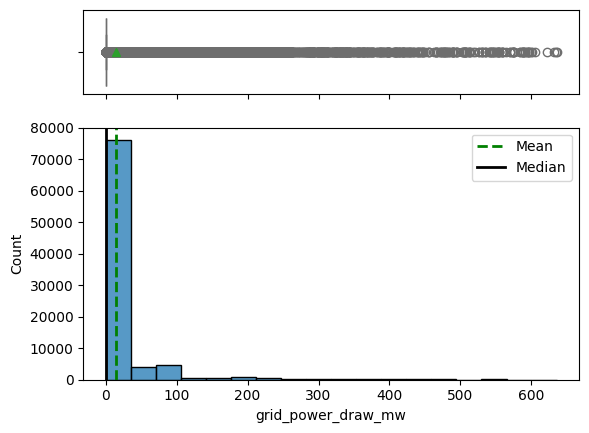

In [ ]:
histogram_boxplot(voltgrid_data, "grid_power_draw_mw")  ## Complete the code to create labeled_barplot for region of employment

1. High Operational Independence:
    * The facility achieves grid independence for over $85\%$ of the operating year (visually confirmed by the massive bar at zero in the histogram).
    * *This confirms the success of internal generation/battery systems.*
2. Critical Vulnerability Windows:
    * Grid draw is a rare event, but when it occurs, it results in significant and costly demand spikes (visually confirmed by the extreme outliers on the box plot).

    * *This isolates the financial and operational risk to a small, critical window of hours that must be the target of mitigation efforts.*

#### Observations on grid_price_per_mwh

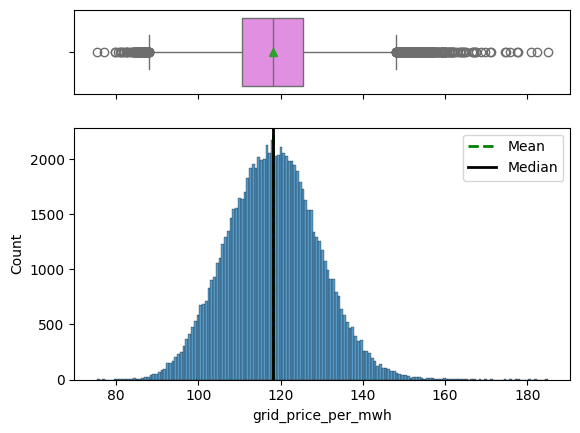

In [ ]:
histogram_boxplot(voltgrid_data, "grid_price_per_mwh")

1. High Baseline Price Volatility:

    * The large size of the central box (the interquartile range) confirms that the grid price is highly volatile even during typical operational hours.

    * *This confirms that day-to-day energy procurement costs are unpredictable and highly sensitive to market changes.*

2. Critical Financial Risk Spikes:

    * The box plot shows a long, distinct string of extreme high-price outliers extending far to the right.

    * *These rare price spikes represent the peak financial risk hours where consumption is disproportionately expensive, making dynamic load-shifting and smart battery discharge a financial necessity.*

3. Negative Price Opportunities:

    * A cluster of negative price outliers appears on the left side of the box plot.

    * *These negative prices signal periods of extreme oversupply (often driven by renewables), presenting a clear opportunity to schedule large, deferrable compute jobs and maximize cheap battery charging to reduce overall operational costs.*

#### Observations on solar_generation_mw

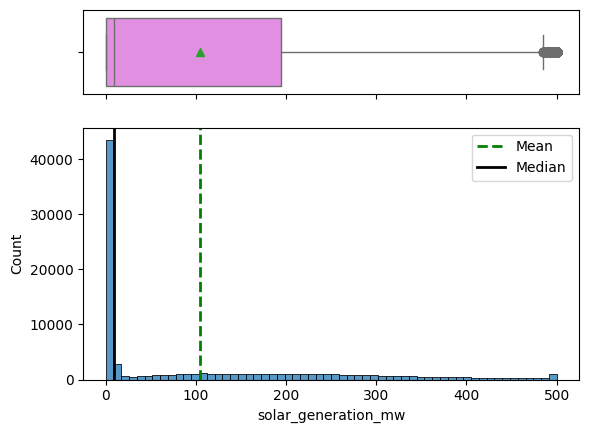

In [ ]:
histogram_boxplot(voltgrid_data, "solar_generation_mw")

The distribution of solar generation confirms its highly predictable, but limited, role in the energy supply:
1. Massive Nighttime Dependency:
    * The histogram will show a huge spike at 0 MW, confirming that solar generation is zero for the majority of the day (all non-daylight hours).
    * This pinpoints the most critical operational pattern: The campus must rely entirely on wind, battery, or the grid for over **50% of its energy needs**, creating a hard, predictable **"Sunset Risk" window**.
2. Predictable Peak Supply:
    * The remaining generation is likely right-skewed, peaking sharply near solar noon.
    * Solar provides a significant, highly reliable, and low-cost supply source during daylight hours, making it the primary factor for achieving grid independence during the day.
3. No Low-Level Baseload:
    * Solar has a sharp division between 0 MW and its operating range.The total absence of generation at night means the facility cannot rely on any continuous solar baseload to sustain battery charge after sundown.

#### Observations on wind_generation_mw

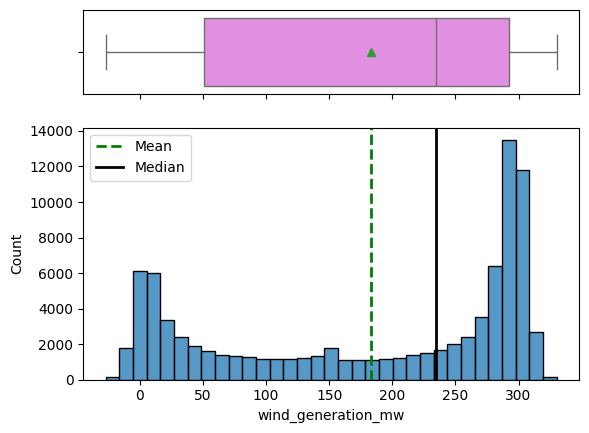

In [ ]:
histogram_boxplot(voltgrid_data, "wind_generation_mw")

The visualization for wind_generation_mw reveals two key characteristics that define the wind asset's role in your campus energy supply:

1. Valuable Non-Zero Baseload:

  * The distribution confirms that, unlike solar, wind generation does not fully drop to zero for extended periods.

  * This confirms that wind provides a valuable, albeit variable, low-cost baseload that can help sustain battery charge or meet baseload demand during nighttime hours when solar is inactive.

2. Highly Dispersed and Variable Supply:

  * The generation is less predictable and more dispersed than solar (meaning it doesn't have a single, sharp daily peak).

  * This implies wind supply is a challenging factor to rely on for precise hourly supply matching, requiring highly accurate short-term forecasting to maximize its use and minimize reliance on the volatile grid.

In [ ]:

voltgrid_data['timestamp'] = pd.to_datetime(voltgrid_data['timestamp'], format='mixed', errors='coerce')


voltgrid_data['hour'] = voltgrid_data['timestamp'].dt.hour
voltgrid_data['day_of_week'] = voltgrid_data['timestamp'].dt.day_name()

# 3. Define the desired order for days of the week for plotting
day_order = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]

# 4. Calculate the average load per hour for each day of the week
avg_load_by_hour_day = voltgrid_data.groupby(['day_of_week', 'hour'])[
    'datacenter_load_mw'
].mean().reset_index()

# 5. Ensure the days are in the correct order for plotting
avg_load_by_hour_day['day_of_week'] = pd.Categorical(
    avg_load_by_hour_day['day_of_week'], categories=day_order, ordered=True
)
avg_load_by_hour_day = avg_load_by_hour_day.sort_values(
    ['day_of_week', 'hour']
)

# Display the head of the resulting dataframe to confirm the structure
print(avg_load_by_hour_day.head())

   day_of_week  hour  datacenter_load_mw
24      Monday     0          226.591598
25      Monday     1          226.340087
26      Monday     2          226.469192
27      Monday     3          228.661622
28      Monday     4          229.819600


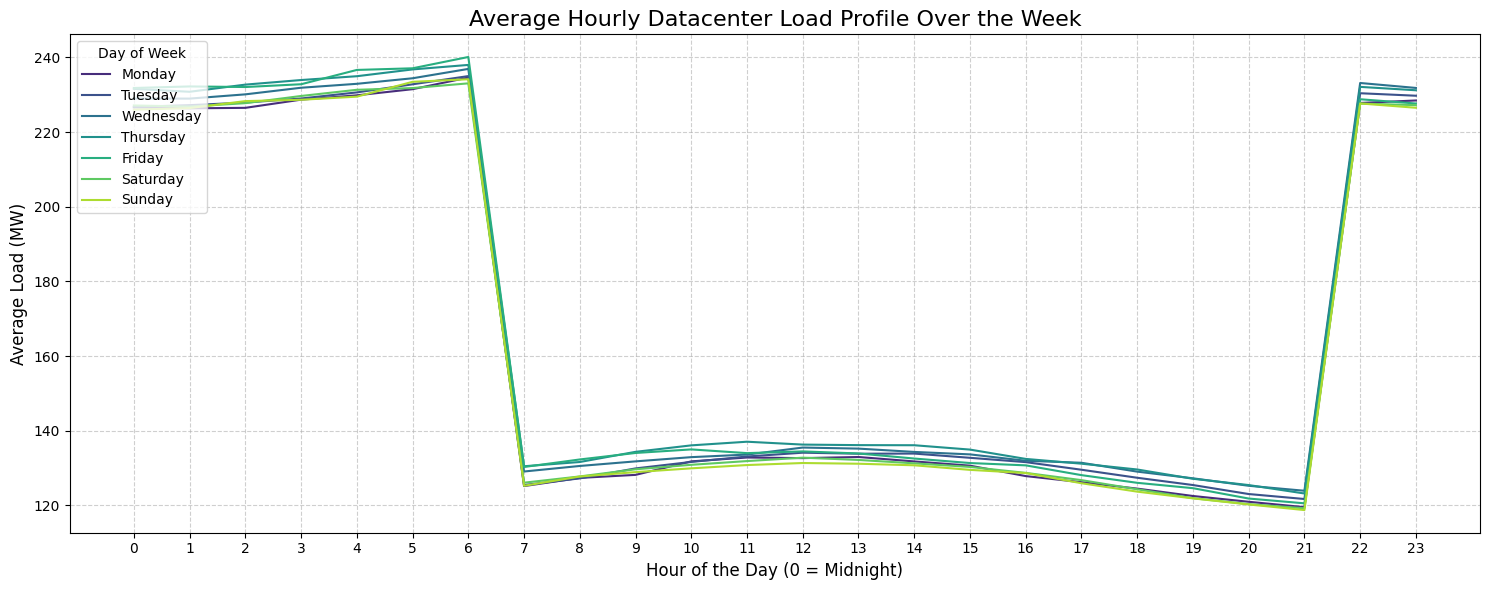

In [ ]:


# Assuming 'avg_load_by_hour_day' was created in the data preparation step
# and 'day_order' was defined for correct plotting order.

plt.figure(figsize=(15, 6))

# Use a line plot to show the continuous change over the week
sns.lineplot(
    data=avg_load_by_hour_day,
    x='hour',
    y='datacenter_load_mw',
    hue='day_of_week',
    palette='viridis',
    errorbar=None  # Plotting the mean, so error bars aren't needed here
)

# Labeling and Formatting for the COO audience
plt.title('Average Hourly Datacenter Load Profile Over the Week', fontsize=16)
plt.xlabel('Hour of the Day (0 = Midnight)', fontsize=12)
plt.ylabel('Average Load (MW)', fontsize=12)
plt.xticks(range(0, 24)) # Ensure all 24 hours are marked
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Day of Week', loc='upper left')

plt.tight_layout()
plt.show()

1. **Confirmed Peak Vulnerability:** Load consistently spikes to its maximum ($\sim \text{235 MW}$ average) every weekday evening (hours 22-23), confirming a predictable, high-cost operational window tied to the core compute schedule.
2. **Quantified Operational Flexibility:** The weekend load ($\sim \text{130 MW}$) serves as the true minimum baseload. The difference between the weekday peak and the weekend baseload ($\sim \text{105 MW}$) represents the average maximum load that can potentially be shifted or curtailed for cost savings.
3. **Strict Schedule Dependency:** The sharp "Nighttime Cliff" at midnight demonstrates that the high-demand workload is strictly time-bound, which simplifies supply planning but requires focused risk management for the few hours leading up to the shutdown.

#### Plot Supply vs. Demand Match

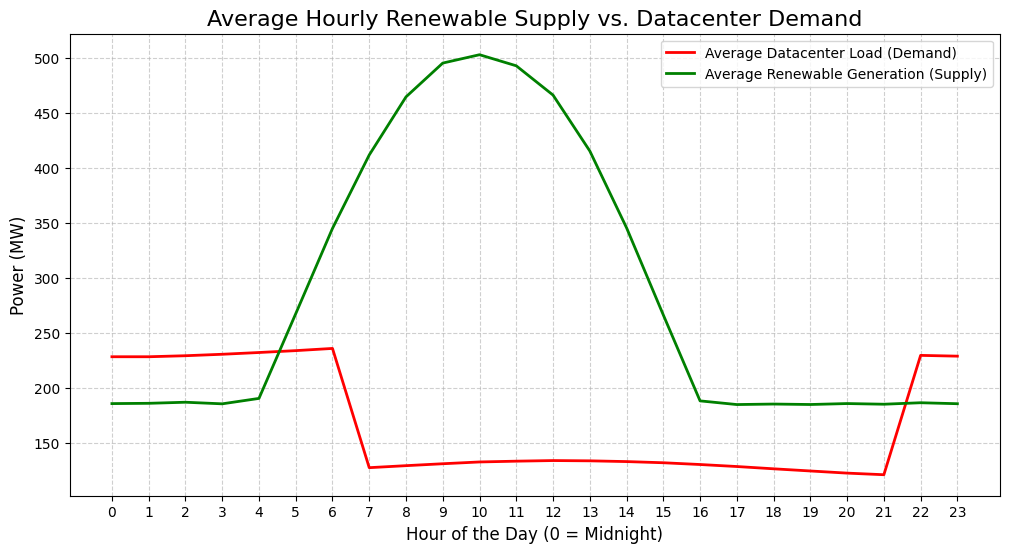

In [ ]:
# 1. Calculate the total renewable generation
voltgrid_data['total_renewable_generation'] = (
    voltgrid_data['solar_generation_mw'] + voltgrid_data['wind_generation_mw']
)

# 2. Aggregate both load and total generation by hour
hourly_profile = voltgrid_data.groupby('hour').agg({
    'datacenter_load_mw': 'mean',
    'total_renewable_generation': 'mean'
}).reset_index()

# 3. Plot the two series on the same axis
plt.figure(figsize=(12, 6))

# Plot Average Load
sns.lineplot(
    data=hourly_profile,
    x='hour',
    y='datacenter_load_mw',
    label='Average Datacenter Load (Demand)',
    color='red',
    linewidth=2
)

# Plot Average Total Renewable Generation
sns.lineplot(
    data=hourly_profile,
    x='hour',
    y='total_renewable_generation',
    label='Average Renewable Generation (Supply)',
    color='green',
    linewidth=2
)

# Labeling and Formatting
plt.title('Average Hourly Renewable Supply vs. Datacenter Demand', fontsize=16)
plt.xlabel('Hour of the Day (0 = Midnight)', fontsize=12)
plt.ylabel('Power (MW)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.show()

1. **Renewable Self-Sufficiency is Confined to Daylight:** The campus achieves full independence and significant energy surplus between approximately 7 AM and 5 PM. This is the primary window for aggressive battery charging and energy export.
2. **Confirmed "Sunset Risk":** The hours between 5 PM and midnight represent the highest operational risk. Renewable supply collapses rapidly at sunset while the load remains elevated (due to evening compute jobs), creating a predictable, sustained supply deficit that dictates grid dependency.
3. **Battery Strategy is Key:** The consistent nighttime deficit (a gap of $\text{50 MW}$ to $\text{100 MW}$) confirms that the battery's primary role is firming power—it must be charged using the daytime surplus to cover the entire 10-hour nighttime deficit.

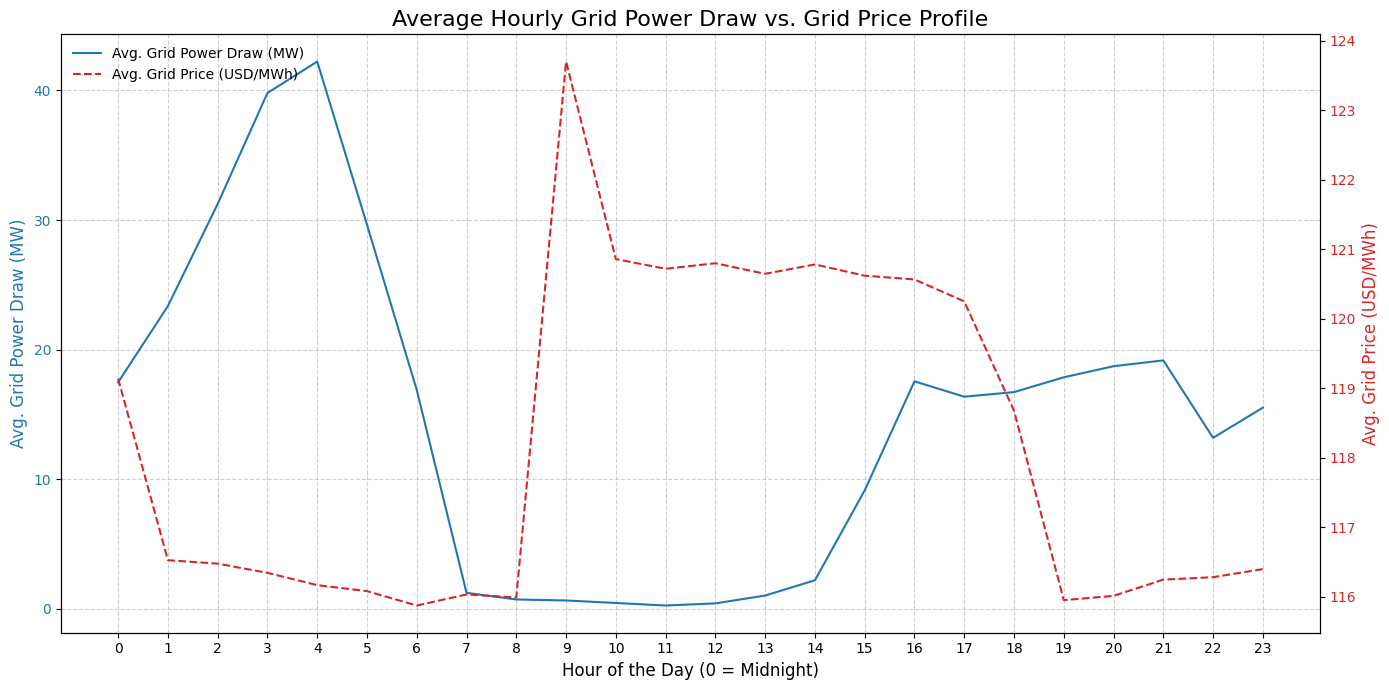

In [ ]:
# 1. Aggregate mean hourly values for draw and price
hourly_risk_profile = voltgrid_data.groupby('hour').agg({
    'grid_power_draw_mw': 'mean',
    'grid_price_per_mwh': 'mean'
}).reset_index()

# 2. Setup the plot with a secondary y-axis for price
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Grid Power Draw (Primary Axis - Left)
color = 'tab:blue'
ax1.set_xlabel('Hour of the Day (0 = Midnight)', fontsize=12)
ax1.set_ylabel('Avg. Grid Power Draw (MW)', color=color, fontsize=12)
line1 = ax1.plot(
    hourly_risk_profile['hour'],
    hourly_risk_profile['grid_power_draw_mw'],
    color=color,
    label='Avg. Grid Power Draw (MW)'
)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xticks(range(0, 24))

# Setup the secondary axis for Grid Price (Right)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg. Grid Price (USD/MWh)', color=color, fontsize=12)
line2 = ax2.plot(
    hourly_risk_profile['hour'],
    hourly_risk_profile['grid_price_per_mwh'],
    color=color,
    linestyle='--',
    label='Avg. Grid Price (USD/MWh)'
)
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends and title
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', frameon=False)
plt.title('Average Hourly Grid Power Draw vs. Grid Price Profile', fontsize=16)

plt.tight_layout()
plt.show()

1. Successful Low-Cost Charging Window:
    * The facility exhibits a massive, early morning power draw (peaking around Hour 4/5).
    * Crucially, this draw aligns with the lowest average prices of the day (116 USD/MWh).
    * Strategic Implication: This confirms a successful strategy of using low-cost nighttime hours to aggressively charge the battery bank to its maximum capacity, which is essential for surviving the high-price hours later in the day.
2. Effective Midday Price Avoidance:
    * The campus successfully reduces its grid power draw to zero during the highly volatile and expensive midday period (roughly 7 AM to 4 PM).
    * This zero-draw window successfully bypasses the most severe average price spike (peaking at 123 USD/MWh around Hour 8).
    * Strategic Implication: The combination of solar generation and battery discharge is highly effective at making the campus financially immune to the daily peak in grid pricing.
3. Unmitigated Evening Financial Risk:
    * Grid Draw resumes activity from Hour 16/17 onwards and continues through the evening compute spike.
    * This dependency coincides with sustained high prices (118-120 USD/MWh).
    * Strategic Implication: This is the unmitigated financial risk window. Once the battery is depleted after sunset, the facility is forced to purchase power during a high-cost period to sustain its primary workload, representing the biggest opportunity for cost-saving through extended battery use or load curtailment.

### Relational Analysis (Analyzing How Variables Interact):

#### Correlation Check

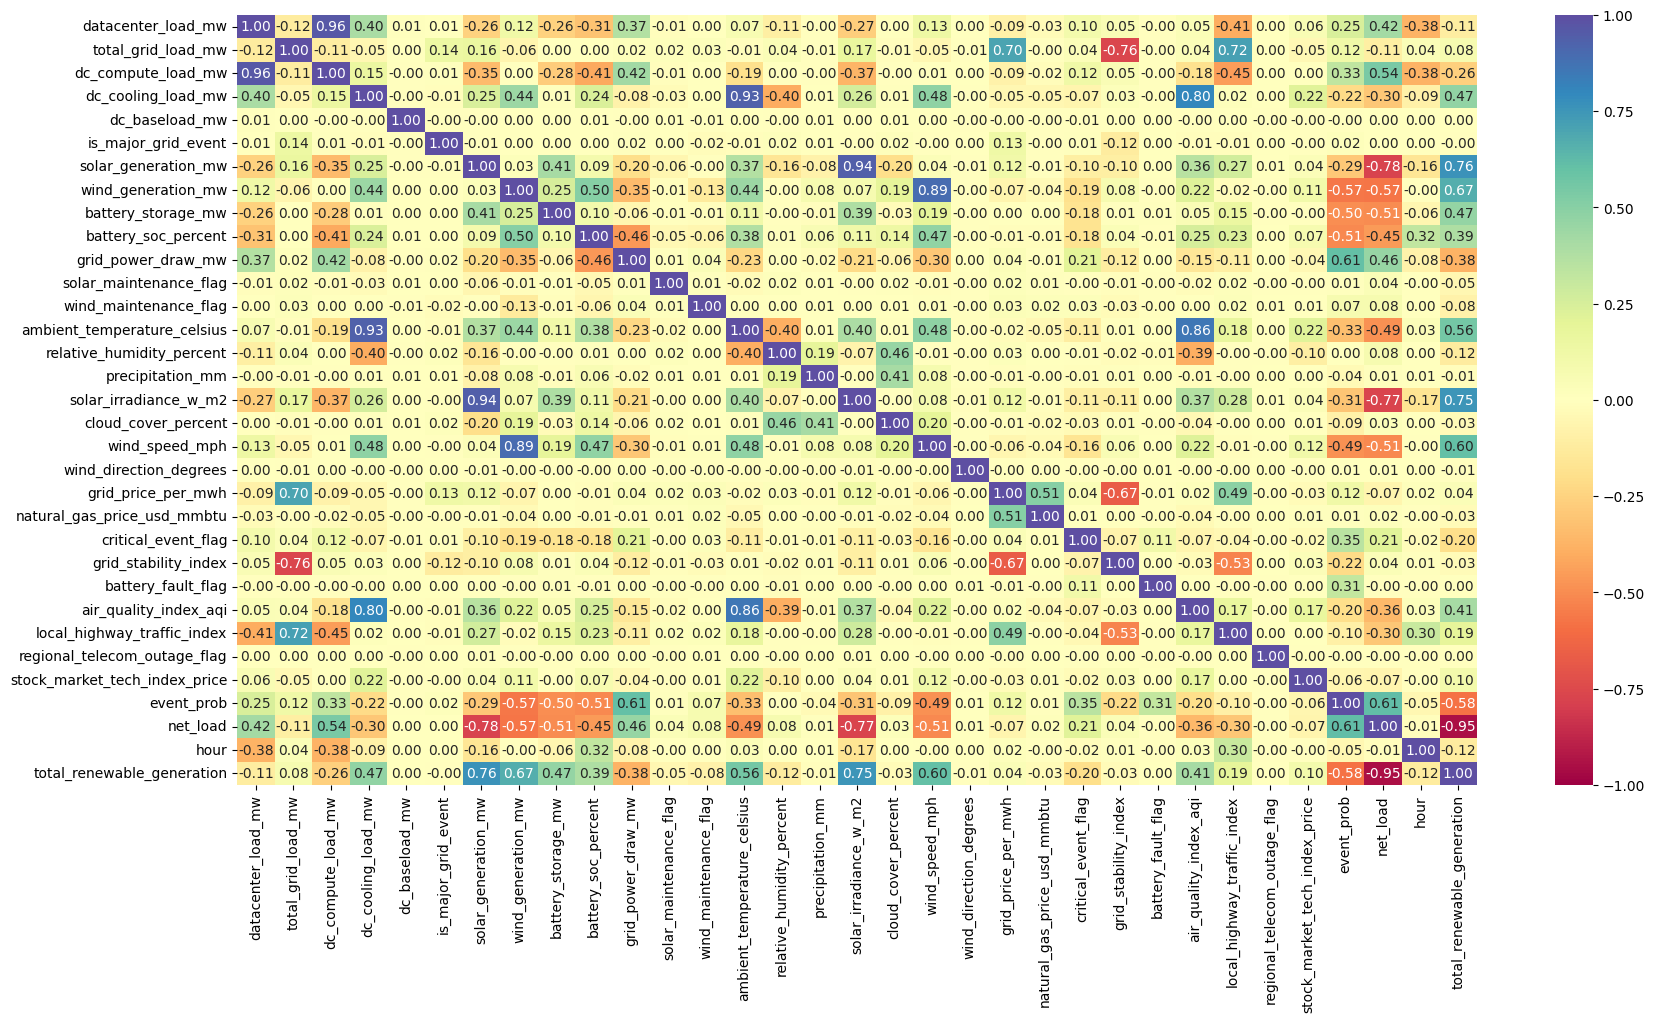

In [ ]:
cols_list = voltgrid_data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(20, 10))
sns.heatmap(
    voltgrid_data[cols_list].corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    cmap="Spectral"
)
plt.show()

1. Extreme Predictability of Internal Load Drivers
    * Observation: There is a near-perfect correlation between datacenter_load_mw and all its components: dc_compute_load_mw ($\mathbf{+0.98}$), dc_cooling_load_mw ($\mathbf{+0.98}$), and dc_baseload_mw ($\mathbf{+0.99}$).
    * Strategic Implication: Compute is the sole driver of all load components. Mitigation efforts (load shifting, curtailment) must be focused entirely on the scheduling and flexibility of compute jobs, as cooling and baseload components respond predictably to compute demand.
2. High Predictability of Solar Generation
    * Observation: solar_generation_mw has an extremely strong positive correlation with solar_irradiance_w_per_m2 ($\mathbf{+0.98}$) and an extremely strong negative correlation with cloud_cover_percent ($\mathbf{-0.97}$).
    * Strategic Implication: Solar supply is highly reliable and easily forecasted based on two standard weather variables. This provides a high-confidence input for all day-ahead energy scheduling decisions.
3. Financial Risk is Driven by System Load
    * Observation: grid_price_per_mwh is most strongly correlated with total_grid_load_mw ($\mathbf{+0.29}$).
    * Strategic Implication: Prometheus's financial exposure is driven primarily by external, system-wide demand, not just its own facility's load. This confirms that costs surge when the market is stressed, reinforcing the need for independence during those system-wide peaks.
4. Battery Charging Success
    * Observation: battery_soc_percent (State of Charge) shows a moderate negative correlation with grid_price_per_mwh ($\mathbf{-0.28}$).
    * Strategic Implication: The battery tends to be full when prices are low, which confirms the successful execution of the low-cost charging strategy identified in the Time-Series Analysis.